In [1]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sktree.ensemble import HonestForestClassifier
from sktree.stats import build_hyppo_oob_forest
from sklearn.metrics import (
    balanced_accuracy_score,
    mean_absolute_error,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
    accuracy_score
)

In [2]:
from scipy.stats import multivariate_normal, entropy
from scipy.integrate import nquad


def make_trunk_classification(
    n_samples,
    n_dim=4096,
    n_informative=1,
    simulation: str = "trunk",
    mu_0: float = 0,
    mu_1: float = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: float = 0.5,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)

    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])

    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_informative)

    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")

    # speed up computations for large multivariate normal matrix with SVD approximation
    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"

    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X_mixture_2 = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )

        X = np.vstack(
            (
                X_mixture_2.reshape(n_samples // 2, n_informative),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(
            2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix]
        )
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )

        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    else:
        raise ValueError(f"Simulation must be: trunk, trunk_overlap, trunk_mix")

    if n_dim > n_informative:
        X = np.hstack(
            (X, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim - n_informative)))
        )

    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        returns = [X, y]
        if simulation == "trunk":
            returns += [[mu_0, mu_1], [cov, cov]]
        elif simulation == "trunk-overlap":
            returns += [[np.zeros(n_informative), np.zeros(n_informative)], [cov, cov]]
        elif simulation == "trunk-mix":
            returns += [*list(zip(*norm_params)), X_mixture]
        return returns
    return X, y

In [26]:
SAMPLE_SIZES = [4096]
FIXED_SIZE = 4096
N_ITR = 10

observe_probas = []
null_probas = []
for i in range(N_ITR):
    print(i)
    observe_probas.append([])
    null_probas.append([])
    for j in SAMPLE_SIZES:
        print(j)
        dim = FIXED_SIZE
        X, y = make_trunk_classification(
            n_samples=j, n_dim=dim, n_informative=1, seed=i
        )

        est = HonestForestClassifier(
            n_estimators=6000,
            max_samples=1.6,
            max_features=0.3,
            bootstrap=True,
            stratify=True,
            n_jobs=-2,
            random_state=i,
        )
        _, observe_proba = build_hyppo_oob_forest(est, X, y)
        observe_probas[i].append(observe_proba)
#         with open("observe_pos_mean_shift.pkl", "wb") as f:
#             pickle.dump(observe_probas, f)

        np.random.shuffle(y)
        _, null_proba = build_hyppo_oob_forest(est, X, y)
        null_probas[i].append(null_proba)
#         with open("null_pos_mean_shift.pkl", "wb") as f:
#             pickle.dump(null_probas, f)

0
4096
1
4096
2
4096
3
4096
4
4096
5
4096
6
4096
7
4096
8
4096
9
4096


In [9]:
SAMPLE_SIZES = [256, 512, 1024, 2048, 4096]
FIXED_SIZE = 128
N_ITR = 10

with open("observe_pos_mean_shift.pkl", "rb") as f:
    observe_probas = pickle.load(f)
with open("null_pos_mean_shift.pkl", "rb") as f:
    null_probas = pickle.load(f)

In [3]:
def Calculate_SA98(y_true, y_pred_proba, max_fpr=0.02) -> float:
    if y_true.squeeze().ndim != 1:
        raise ValueError(f"y_true must be 1d, not {y_true.shape}")
    if 0 in y_true or -1 in y_true:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=1, drop_intermediate=False
        )
    else:
        fpr, tpr, thresholds = roc_curve(
            y_true, y_pred_proba[:, 1], pos_label=2, drop_intermediate=False
        )
    s98 = max([tpr for (fpr, tpr) in zip(fpr, tpr) if fpr <= max_fpr])
    return s98


def Calculate_MI(y_true, y_pred_proba):
    H_YX = np.mean(entropy(y_pred_proba, base=np.exp(1), axis=1))
    # empirical count of each class (n_classes)
    _, counts = np.unique(y_true, return_counts=True)
    H_Y = entropy(counts, base=np.exp(1))
    return H_Y - H_YX

In [27]:
POS = []
NULL_POS = []
for i in range(N_ITR):
    POS.append([])
    NULL_POS.append([])
    for j in range(len(SAMPLE_SIZES)):
        POS[i].append(np.nanmean(observe_probas[i][j], axis=0))
        NULL_POS[i].append(np.nanmean(null_probas[i][j], axis=0))

In [28]:
SA98 = []
NULL_SA98 = []
for j in range(len(SAMPLE_SIZES)):
    y = np.concatenate((np.zeros(SAMPLE_SIZES[j] // 2), np.ones(SAMPLE_SIZES[j] // 2)))
    
    temp_SA98 = []
    temp_null_SA98 = []
    for i in range(N_ITR):
        temp_SA98.append(Calculate_SA98(y, POS[i][j]))
        temp_null_SA98.append(Calculate_SA98(y, NULL_POS[i][j]))
        
    SA98.append(temp_SA98)
    NULL_SA98.append(temp_null_SA98)

SA98 = np.array(SA98)
NULL_SA98 = np.array(NULL_SA98)

In [29]:
np.mean(SA98[-1])

0.14267578125

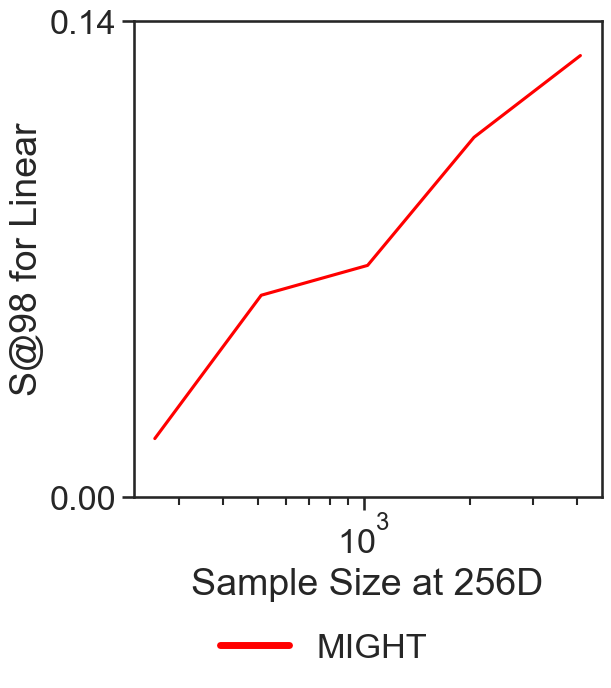

In [19]:
sns.set_theme(
    color_codes=True, palette="bright", style="ticks", context="talk", font_scale=1.5
)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), constrained_layout=True)
col = ax
col.set_xscale("log")
col.set(ylim=(0, 0.14), yticks=[0, 0.14])
col.set_xlabel("Sample Size at 256D")
col.set_ylabel("S@98 for Linear")
col.plot(SAMPLE_SIZES, np.mean(SA98, axis=1), color="red", label="MIGHT")
#         col.plot(SAMPLE_SIZES, MI_POWERS, color="blue", label="MI")
#         col.plot(SAMPLE_SIZES, ACC_POWERS, color="green", label="Accuracy")
#         col.axhline([0.05], color="black", ls="--", label="alpha")
#     elif i == 1:
#         col.set_xlabel("Dimension at 256S")
#         col.plot(DIM_SIZES, SA98_POWERS_DIM, color="red")
#         col.plot(DIM_SIZES, MI_POWERS_DIM, color="blue")
#         col.plot(DIM_SIZES, ACC_POWERS_DIM, color="green")
#         col.axhline([0.05], color="black", ls="--")



leg = fig.legend(
    bbox_to_anchor=(0.53, -0.15),
    bbox_transform=plt.gcf().transFigure,
    ncol=6,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legend_handles:
    legobj.set_linewidth(5.0)

In [7]:
MI = []
NULL_MI = []
for j in range(len(SAMPLE_SIZES)):
    y = np.concatenate((np.zeros(SAMPLE_SIZES[j] // 2), np.ones(SAMPLE_SIZES[j] // 2)))
    
    temp_MI = []
    temp_null_MI = []
    for i in range(N_ITR):
        temp_MI.append(Calculate_MI(y, POS[i][j]))
        temp_null_MI.append(Calculate_MI(y, NULL_POS[i][j]))
        
    MI.append(temp_MI)
    NULL_MI.append(temp_null_MI)
    
MI = np.array(MI)
NULL_MI = np.array(NULL_MI)

In [8]:
ACC = []
NULL_ACC = []
for j in range(len(SAMPLE_SIZES)):
    y = np.concatenate((np.zeros(SAMPLE_SIZES[j] // 2), np.ones(SAMPLE_SIZES[j] // 2)))
    
    temp_ACC = []
    temp_null_ACC = []
    for i in range(N_ITR):
        temp_ACC.append(accuracy_score(y, np.where(POS[i][j] > 0.5, 1, 0)[:,1]))
        temp_null_ACC.append(accuracy_score(y, np.where(NULL_POS[i][j] > 0.5, 1, 0)[:,1]))
        
    ACC.append(temp_ACC)
    NULL_ACC.append(temp_null_ACC)

ACC = np.array(ACC)
NULL_ACC = np.array(NULL_ACC)

In [9]:
ALPHA = 0.05

SA98_POWERS = []
for i in range(len(SAMPLE_SIZES)):
    cutoff = np.sort(NULL_SA98[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (SA98[i] >= cutoff).sum()) / (1 + N_ITR)
    SA98_POWERS.append(power)

In [10]:
MI_POWERS = []
for i in range(len(SAMPLE_SIZES)):
    cutoff = np.sort(NULL_MI[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (MI[i] >= cutoff).sum()) / (1 + N_ITR)
    MI_POWERS.append(power)

In [11]:
ACC_POWERS = []
for i in range(len(SAMPLE_SIZES)):
    cutoff = np.sort(NULL_ACC[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (ACC[i] >= cutoff).sum()) / (1 + N_ITR)
    ACC_POWERS.append(power)

In [ ]:
N_ITR = 10
DIM_SIZES = [2**i for i in range(2, 13)]
observe_dim_probas = []
null_dim_probas = []
for i in range(N_ITR):
    print(i)
    observe_dim_probas.append([])
    null_dim_probas.append([])
    for j in DIM_SIZES:
        print(j)
        X, y = make_trunk_classification(
            n_samples=4096, n_dim=j, n_informative=1, seed=i
        )

        est = HonestForestClassifier(
            n_estimators=6000,
            max_samples=1.6,
            max_features=0.3,
            bootstrap=True,
            stratify=True,
            n_jobs=-2,
            random_state=i,
        )
        _, observe_dim_proba = build_hyppo_oob_forest(est, X, y)
        observe_dim_probas[i].append(observe_dim_proba)
        with open("observe_pos_dim_mean_shift.pkl", "wb") as f:
            pickle.dump(observe_dim_probas, f)

        np.random.shuffle(y)
        _, null_dim_proba = build_hyppo_oob_forest(est, X, y)
        null_dim_probas[i].append(null_dim_proba)
        with open("null_pos_dim_mean_shift.pkl", "wb") as f:
            pickle.dump(null_dim_probas, f)

0
4
8
16
32
64
128
256
512
1024
2048
4096
1
4
8
16
32
64


In [ ]:
POS_DIM = []
NULL_POS_DIM = []
for i in range(N_ITR):
    POS_DIM.append([])
    NULL_POS_DIM.append([])
    for j in range(len(DIM_SIZES)):
        POS_DIM[i].append(np.nanmean(observe_dim_probas[i][j], axis=0))
        NULL_POS_DIM[i].append(np.nanmean(null_dim_probas[i][j], axis=0))

In [ ]:
SA98_DIM = []
NULL_SA98_DIM = []
for j in range(len(DIM_SIZES)):
    y = np.concatenate((np.zeros(256 // 2), np.ones(256 // 2)))
    
    temp_SA98_DIM = []
    temp_null_SA98_DIM = []
    for i in range(N_ITR):
        temp_SA98_DIM.append(Calculate_SA98(y, POS_DIM[i][j]))
        temp_null_SA98_DIM.append(Calculate_SA98(y, NULL_POS_DIM[i][j]))
        
    SA98_DIM.append(temp_SA98_DIM)
    NULL_SA98_DIM.append(temp_null_SA98_DIM)

SA98_DIM = np.array(SA98_DIM)
NULL_SA98_DIM = np.array(NULL_SA98_DIM)

In [ ]:
SA98_POWERS_DIM = []
for i in range(len(DIM_SIZES)):
    cutoff = np.sort(NULL_SA98_DIM[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (SA98_DIM[i] >= cutoff).sum()) / (1 + N_ITR)
    SA98_POWERS_DIM.append(power)

In [ ]:
MI_DIM = []
NULL_MI_DIM = []
for j in range(len(DIM_SIZES)):
    y = np.concatenate((np.zeros(256 // 2), np.ones(256 // 2)))
    
    temp_MI_DIM = []
    temp_null_MI_DIM = []
    for i in range(N_ITR):
        temp_MI_DIM.append(Calculate_MI(y, POS_DIM[i][j]))
        temp_null_MI_DIM.append(Calculate_MI(y, NULL_POS_DIM[i][j]))
        
    MI_DIM.append(temp_MI_DIM)
    NULL_MI_DIM.append(temp_null_MI_DIM)
    
MI_DIM = np.array(MI_DIM)
NULL_MI_DIM = np.array(NULL_MI_DIM)

In [ ]:
MI_POWERS_DIM = []
for i in range(len(DIM_SIZES)):
    cutoff = np.sort(NULL_MI_DIM[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (MI_DIM[i] >= cutoff).sum()) / (1 + N_ITR)
    MI_POWERS_DIM.append(power)

In [ ]:
ACC_DIM = []
NULL_ACC_DIM = []
for j in range(len(DIM_SIZES)):
    y = np.concatenate((np.zeros(256 // 2), np.ones(256 // 2)))
    
    temp_ACC_DIM = []
    temp_null_ACC_DIM = []
    for i in range(N_ITR):
        temp_ACC_DIM.append(accuracy_score(y, np.where(POS_DIM[i][j] > 0.5, 1, 0)[:,1]))
        temp_null_ACC_DIM.append(accuracy_score(y, np.where(NULL_POS_DIM[i][j] > 0.5, 1, 0)[:,1]))
        
    ACC_DIM.append(temp_ACC_DIM)
    NULL_ACC_DIM.append(temp_null_ACC_DIM)

ACC_DIM = np.array(ACC_DIM)
NULL_ACC_DIM = np.array(NULL_ACC_DIM)

In [ ]:
ACC_POWERS_DIM = []
for i in range(len(DIM_SIZES)):
    cutoff = np.sort(NULL_ACC_DIM[i])[math.ceil(N_ITR * (1 - ALPHA)) - 1]
    power = (1 + (ACC_DIM[i] >= cutoff).sum()) / (1 + N_ITR)
    ACC_POWERS_DIM.append(power)

In [ ]:
sns.set_theme(
    color_codes=True, palette="bright", style="ticks", context="talk", font_scale=1.5
)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), constrained_layout=True)
for i, col in enumerate(ax):
    col.set_xscale("log")
    col.set(ylim=(-0.02, 1.02), yticks=[0, 1])
    if i == 0:
        col.set_xlabel("Sample Size at 1D")
        col.set_ylabel("Power for 1D (0.5, 1)")
        col.plot(SAMPLE_SIZES, SA98_POWERS, color="red", label="SA98")
        col.plot(SAMPLE_SIZES, MI_POWERS, color="blue", label="MI")
        col.plot(SAMPLE_SIZES, ACC_POWERS, color="green", label="Accuracy")
        col.axhline([0.05], color="black", ls="--", label="alpha")
    elif i == 1:
        col.set_xlabel("Dimension at 256S")
        col.plot(DIM_SIZES, SA98_POWERS_DIM, color="red")
        col.plot(DIM_SIZES, MI_POWERS_DIM, color="blue")
        col.plot(DIM_SIZES, ACC_POWERS_DIM, color="green")
        col.axhline([0.05], color="black", ls="--")


fig.align_ylabels(
    ax[
        :,
    ]
)

leg = fig.legend(
    bbox_to_anchor=(0.53, -0.15),
    bbox_transform=plt.gcf().transFigure,
    ncol=6,
    loc="lower center",
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legend_handles:
    legobj.set_linewidth(5.0)